# __From Global to Local Cost Functions__

Global cost functions, which involve measurements in many qubits, present barren plateau independently of the shape and the depth of the variational circuit.  For example, consider the $n$-qubits Hamiltonian 

\begin{equation}
H = I^{\otimes n}-|0^{\otimes n}\rangle\langle 0^{\otimes n}|.
\end{equation}

This Hamiltonian require a measurement over $|0^{\otimes n}\rangle$, wich involve all the $n$ qubits. Thereby, the sample of shots $N_{shots}$ used to evaluate $H$ has to split into $2^n$ outputs. In the case $N_{shots}<2^n$, which always happens for large $n$, the number of shots is not enough large to perform a precise evaluation of $H$, so that its gradient vanish and the barren plateau appears.

<img src="https://github.com/jgidi/quantum-barren-plateaus/blob/main/imgs/fig3_from_cost_function_induced_barren_plateau.JPG?raw=true" width=500 style="display: block; margin: 0 auto"  >

In [1] the authors recommend avoiding this kind of Hamiltonian in the early iterations of the algorithm and instead employ a local hamiltonian 

\begin{equation}
H_L = I^{\otimes n}-\frac{1}{n}\sum_{j=1}^n I_{1}\otimes\cdots\otimes I_{j+1}\otimes|0_j\rangle\langle 0_j|\otimes I_{j-1}\otimes\cdots\otimes I_{n}. \tag{2}
\end{equation}

Each term of this hamiltonian involves a single-qubits measurement, so that can be accurately evaluated with a small $N_{shots}$. The authors demonstrate that this kind of Hamiltonian can be used to train variational circuits with depth $\log(n)$. 

<img src="https://github.com/jgidi/quantum-barren-plateaus/blob/main/imgs/fig4_from_cost_function_induced_barren_plateau.JPG?raw=true" width=500 style="display: block; margin: 0 auto"  >



## __Example:__ Autoencoders

As an important example to illustrate the barren plateau phenomena in the cost function, we consider quantum autoncoders $[2]$. This type of algorithms has received significant literature attention, due to its importance in quantum machine learning and quantum data compression.

Consider a bipartite quantum system $AB$ composed of $n_A$ and $n_B$ qubits, respectively, and let $\{p_i, |\psi_i \rangle\}$ be an ensamble of pure states. The goal of the autoencoder is to train the variational quantum circuit $V(\vec{\theta})$ to compress this ensemble into the $A$ subsystem, in order to recover each state $|\psi_i \rangle$ with high fidelity from the information in subsystem $A$.
In [2] the authors proposed the following cost function to quantify the degree of data compression

\begin{align}
C_G = Tr \{O_G V(\vec{\theta}) \rho_{AB}^{in} V(\vec{\theta})^\dagger\} \tag{3}
\end{align}

where $\rho_{AB}^{in} = \Sigma_i p_i |\psi_i \rangle \langle\psi_i|$ is the initial state, and $O_G = \mathrm{I}_{AB} -\mathrm{I}_{A} \otimes |\vec{0} \rangle \langle \vec{0} | $ is a global observable. Acording to Ref. [1], the cost function $C_G$ present barren plateau for large $n_B$. As a result, large-scale data compression will not be possible with $C_G$.

To solve this problem, in Ref. [1] is propose the following local cost function

\begin{align}
C_G = Tr \{O_L V(\vec{\theta}) \rho_{AB}^{in} V(\vec{\theta})^\dagger\} \tag{4}
\end{align}

where $O_L$ is the local observable that we can obtain from reducing the global observable $O_G$. The local cost function in eq. (4) does not exhibit a barren plateau for shallow ansatzes as we will see in the following case.

We simulate the autoencoder algorithm when $n_{A}=1$ and the input state is given by 

\begin{align}
|\Psi_1\rangle &= |0\rangle_{A} \otimes |0,0,0, ..., 0 \rangle_{B}, \quad \text{with} \; p_1=2/3, \\
|\Psi_2\rangle &= |1\rangle_{A} \otimes |1,1,0, ..., 0 \rangle_{B}, \quad \text{with} \; p_1=1/3. \\
\end{align}

For this example, we consider the case when $n_B = 7$. 

Before continuing with the circuit, we import some standard libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit.utils import QuantumInstance

And also we import the Quantum Barren Plateaus (`qubap`) module in the qiskit version.

In [4]:
import sys
sys.path.append('../..')

from qubap.qiskit.cost_function_barren_plateau import initial_state_ex, variational_circuit, global_observable, local_observable, ansatz_numerical
from qubap.qiskit.variational_algorithms import classical_solver
from qubap.qiskit.variational_algorithms.tools import energy_evaluation
from qubap.qiskit.variational_algorithms.VQEs import VQE, VQE_shift


ModuleNotFoundError: No module named 'qubap'

Then the density matrix given by the states in eq. (1) and (2) can be generated by the following quantum circuit

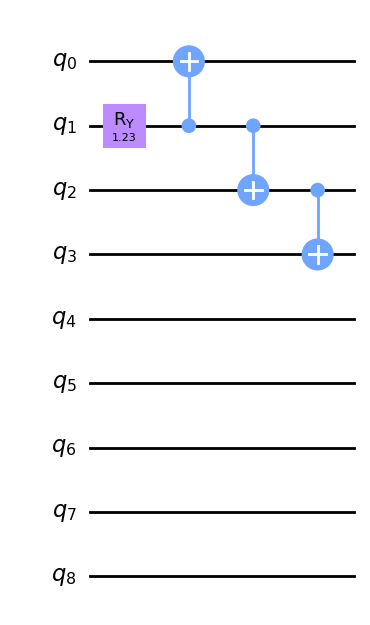

In [23]:
n_B = 7
n_A = 1
initial_state_ex(n_B, n_A).draw("mpl")

Here the register "$q_1$" correspond to Alice's qubit, and the registers from "$q_2$" to "$q_3$" belong to Bob's qubits. Aditionally, we add an ancilla state in the register "$q_0$".

Adittionally we use the variational quantum circuit proposed in Fig. 4 of Ref. [1], which for $n_B=10$ is written as

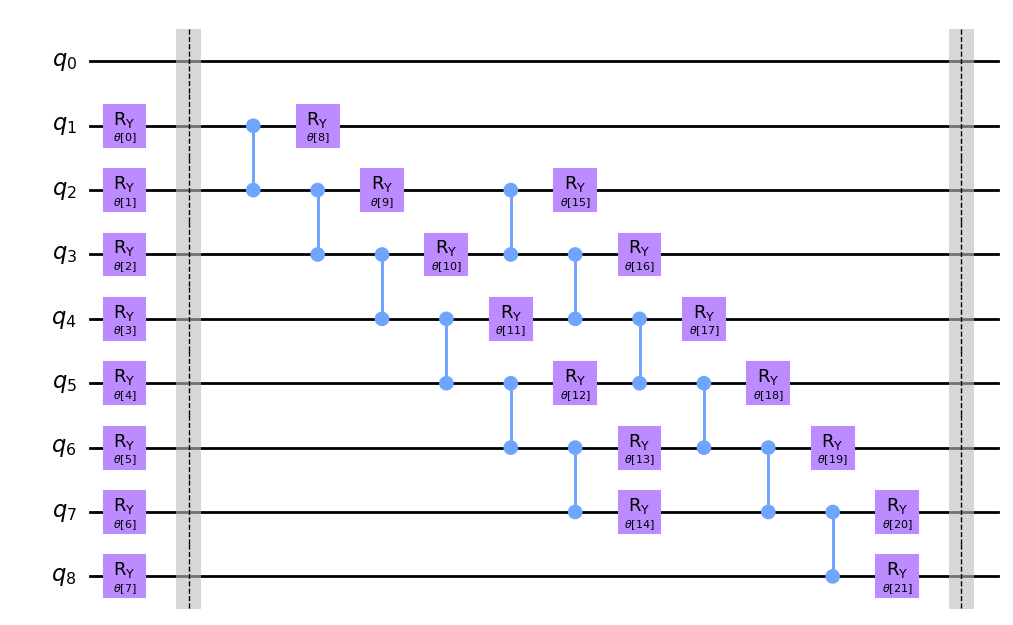

In [24]:
layers = 1
variational_circuit(n_B,n_A,layers).draw("mpl")

We can increase the deep of the circuit by adding more layers. Each layer is contain between the barriers.

We compose both circuits in the function `ansatz_numerical`, wich is our ansatz to train our variational circuit. Note that the variational quantum circuit is trainable until $O(\log{n})$, in our case, the maximum numbers of layers will be 2.


In [25]:
layers =2
ansatz = ansatz_numerical(n_B, n_A, layers)

In [26]:
num_iters = 300
n_total = n_B + n_A
O_global = global_observable(n_B)
O_local = local_observable(n_B)

num_params = 2*n_B*layers + n_total
initial_guess = np.random.randn( num_params ) * np.pi
backend= QuantumInstance(AerSimulator() , shots = 2**5 )

In [28]:
results_vqe= VQE( O_global, ansatz, initial_guess, num_iters, backend)
analitic_results_vqe = [ energy_evaluation(O_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_vqe["x"] ]

In [32]:
num_iters_shift = num_iters//3
results_shift= VQE_shift( O_local, O_global, ansatz, initial_guess, num_iters, num_iters_shift, backend)
analitic_results_local  = [ energy_evaluation( O_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_shift['in']['x'] ]
analitic_results_global = [ energy_evaluation( O_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_shift['out']['x'] ]

In [30]:


exact_min_energy = classical_solver(O_global).eigenvalue
exact_min_energy

0j

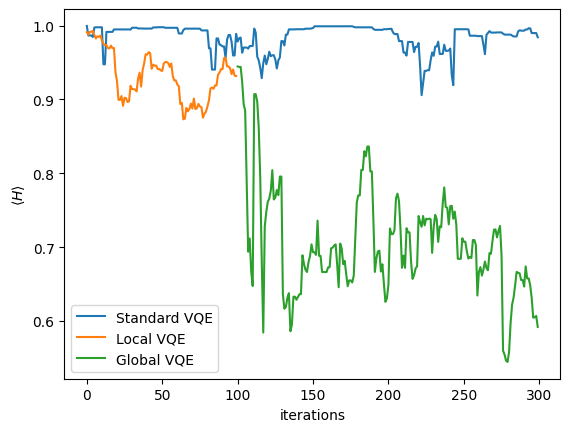

In [34]:
plt.plot( analitic_results_vqe )
plt.plot( analitic_results_local )
plt.plot( range(num_iters_shift,num_iters),  analitic_results_global )
plt.hlines(exact_min_energy, 0, num_iters, 'r', '--')
plt.xlabel('iterations')
plt.ylabel(r'$\langle H \rangle$')
plt.legend(['Standard VQE','Local VQE','Global VQE', 'Min energy'])

### References

[] Cerezo, M., Sone, A., Volkoff, T. et al. Cost function dependent barren plateaus in shallow parametrized quantum circuits. $\textit{Nat Commun}$ $\textbf{12}$, 1791 (2021). https://doi.org/10.1038/s41467-021-21728-w

[] Jonathan Romero et al 2017 $\textit{Quantum Sci. Technol.}$ $\textbf{2}$ 045001

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table